# Code comparison - program 1242 

Comparison of ImPlaneIA, SAMPip, and AMICAL reductions of data from program 1242.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.table import Table

from tqdm import tqdm
from itertools import groupby

from glob import glob
from os import path
from amical.oifits import load

%matplotlib inline

## ImPlaneIA

In [2]:
fnames = glob('../data/testing_1242/implaneia_rachel/jw*.oifits')
print(len(fnames), 'files found')
print(fnames)
names = [load(fname)['info']['OBJECT'].strip('TD ') for fname in fnames]
numbers = [path.basename(fname).split('_')[0].strip('jw') for fname in fnames]
translate = dict(zip(numbers, names))
print(np.unique(names))


17 files found
['../data/testing_1242/implaneia_rachel/jw01242004001_03104_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242005001_03103_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242002001_03103_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242003001_03104_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242004001_03105_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242005001_03102_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242002001_03102_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242001001_03104_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242001001_03103_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242003001_03102_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242004001_03102_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw01242005001_03105_00001_nis.oifits', '../data/testing_1242/implaneia_rachel/jw0124200

In [3]:
fname = fnames[0]

Now look at the `multi` datasets. These are multi-exposure datasets that will help us understand bad frames.

In [4]:
fnames_multi = glob('../data/testing_1242/implaneia_rachel/multi*.oifits')
print(len(fnames_multi), 'files')

17 files


In [5]:
# look at one 
multi = load(fnames_multi[0])

Text(0.5, 0.98, 'Integration History of One Dataset')

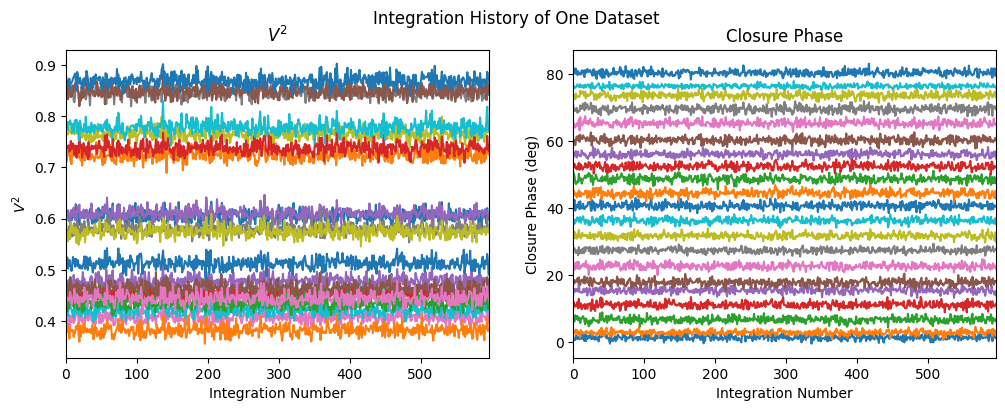

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for j in range(21):
    ax1.plot(multi['OI_VIS2']['VIS2DATA'][j,:])
    ax2.plot(multi['OI_T3']['T3PHI'][j,:]+j*4)


ax1.set_xlim(0,multi['OI_VIS2']['VIS2DATA'].shape[1]-1)
ax2.set_xlim(0,multi['OI_T3']['T3PHI'].shape[1]-1)
ax1.set_xlabel('Integration Number')
ax2.set_xlabel('Integration Number')

ax1.set_title(r'$V^2$')
ax2.set_title('Closure Phase')
ax1.set_ylabel(r'$V^2$')
ax2.set_ylabel('Closure Phase (deg)')

plt.suptitle('Integration History of One Dataset')


Text(0.5, 1.0, 'ImPlaneIA CP Covariance')

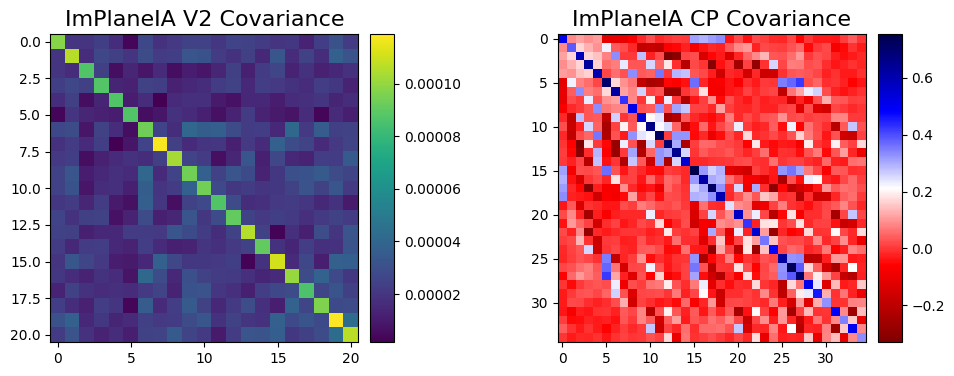

In [7]:
# covariance matrices
v2cov = np.cov(multi['OI_VIS2']['VIS2DATA'])
t3cov = np.cov(multi['OI_T3']['T3PHI'])

vmin_v2, vmax_v2 = np.min(v2cov),np.max(v2cov)
vmin_cp, vmax_cp = np.min(t3cov),np.max(t3cov)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

img_v2_targcov = ax1.imshow(v2cov,vmin=vmin_v2,vmax=vmax_v2)
cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
plt.colorbar(img_v2_targcov,cax=cax)

ax1.set_title('ImPlaneIA V2 Covariance',fontsize=16)

img_cp_targcov = ax2.imshow(t3cov,vmin=vmin_cp,vmax=vmax_cp, cmap=mpl.cm.seismic_r)
cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
plt.colorbar(img_cp_targcov,cax=cax)

ax2.set_title('ImPlaneIA CP Covariance',fontsize=16)



These actually look reasonably stable from integration to integration, with a sensible covariance structure.

Now let's look at all of the targets.

In [8]:
# get the names of the targets and sort them into groups
args = np.argsort(names)
unsort = np.argsort(args)
sorted_strings = [names[j] for j in args]

# group the strings into a list of lists
groups = []
for key, group in groupby(sorted_strings, lambda x: x):

    dummy = list(group)
    dummy[1:] = "-"*len(dummy[1:])
    groups.append(dummy)

groups = np.concatenate(groups)#[unsort]
groups


array(['CAL HD 101531', '-', '-', 'CAL HD 123991', '-', '-', '-',
       'HD 100546', '-', '-', 'HD 135344B', '-', '-', 'PDS 70', '-', '-',
       '-'], dtype='<U13')

In [9]:
# use amical to load the data

def extract_data(fname,joel=False):
    data = load(fname)
    cols = list(data.keys())
    wdata, vdata, v2data, t3data = data['OI_WAVELENGTH'], data['OI_VIS'], data['OI_VIS2'], data['OI_T3']
    wavels, band = wdata['EFF_WAVE'], wdata['EFF_BAND']
    u, v, vis2, vis2err = v2data['UCOORD'], v2data['VCOORD'], v2data['VIS2DATA'], v2data['VIS2ERR']
    t3phi, t3phierr, t3amp, t3amperr, t3u1, t3u2, t3v1, t3v2 = t3data['T3PHI'], t3data['T3PHIERR'], t3data['T3AMP'], \
        t3data['T3AMPERR'], t3data['U1COORD'], t3data['U2COORD'], t3data['V1COORD'], t3data['V2COORD']
    if joel:
        return wavels, band, u, v, vis2, vis2err, t3phi, t3phierr, t3amp, t3amperr, t3u1, t3u2, t3v1, t3v2
    else:
        name = data['info']['OBJECT'].strip('TD ')
        return wavels, band, u, v, vis2, vis2err, t3phi, t3phierr, t3amp, t3amperr, t3u1, t3u2, t3v1, t3v2, name


In [10]:
fname = fnames[0]
wavels, band, u, v, vis2, vis2err, t3phi, t3phierr, t3amp, t3amperr, t3u1, t3u2, t3v1, t3v2, name = extract_data(fname)


Text(0.5, 0.98, 'Data from ../data/testing_1242/implaneia_rachel/jw01242004001_03104_00001_nis.oifits')

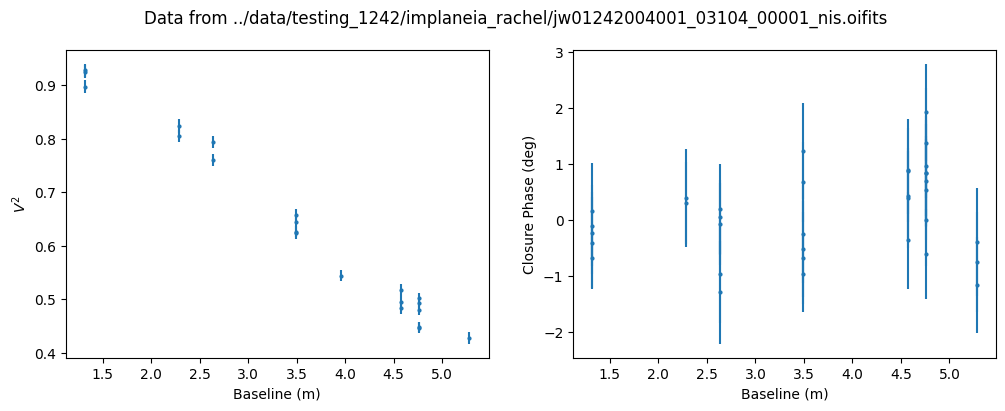

In [11]:
# plot the visibilities and closure phases as a function of baseline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# visibilities
ax1.errorbar(np.sqrt(u**2 + v**2), vis2, yerr=vis2err, fmt='o',markersize=2)
ax1.set_xlabel('Baseline (m)')
ax1.set_ylabel(r'$V^2$')

# closure phases vs first baseline
ax2.errorbar(np.sqrt(t3u1**2 + t3v1**2), t3phi, yerr=t3phierr, fmt='o',markersize=2)
ax2.set_xlabel('Baseline (m)')
ax2.set_ylabel('Closure Phase (deg)')

plt.suptitle('Data from {}'.format(fname))

100%|██████████| 17/17 [00:00<00:00, 70.80it/s]


Text(0.5, 0.98, 'Data from all files in folder')

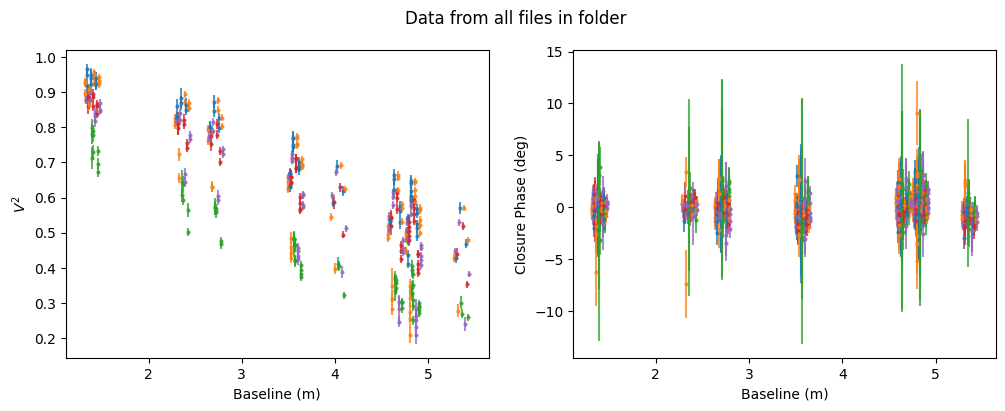

In [12]:
# now do this looping over all datasets in the folder

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for j, fname in enumerate(tqdm(fnames)):

    wavels, band, u, v, vis2, vis2err, t3phi, t3phierr, t3amp, t3amperr, t3u1, t3u2, t3v1, t3v2, name = extract_data(fname)

    num = np.where(np.unique(names) == name)[0]

    # visibilities
    ax1.errorbar(np.sqrt(u**2 + v**2) + (0.01*j), vis2, yerr=vis2err, fmt='o',markersize=2,alpha=0.75,color='C%d' % num)

    # closure phases vs first baseline
    ax2.errorbar(np.sqrt(t3u1**2 + t3v1**2)+ (0.01*j), t3phi, yerr=t3phierr, fmt='o',markersize=2,alpha=0.75,color='C%d' % num)

ax1.set_xlabel('Baseline (m)')
ax1.set_ylabel(r'$V^2$')
ax2.set_xlabel('Baseline (m)')
ax2.set_ylabel('Closure Phase (deg)')

plt.suptitle('Data from all files in folder')

What is the covariance between visibilities across all targets?

In [13]:
# now do covariance matrices of the v2 and t3 data

v2s, t3s = [], []
v2errs, t3errs = [], []

for fname in tqdm([fnames[arg] for arg in args]):

    wavels, band, u, v, vis2, vis2err, t3phi, t3phierr, t3amp, t3amperr, t3u1, t3u2, t3v1, t3v2, name = extract_data(fname)

    # visibilities
    v2s.append(vis2)
    v2errs.append(vis2err)

    # closure phases
    t3s.append(t3phi)
    t3errs.append(t3phierr)

v2s = np.array(v2s).T
t3s = np.array(t3s).T
v2errs = np.array(v2errs).T
t3errs = np.array(t3errs).T

# covariance matrices
v2cov = np.cov(v2s)
t3cov = np.cov(t3s)

vmin_v2, vmax_v2 = np.min(v2cov),np.max(v2cov)
vmin_cp, vmax_cp = np.min(t3cov),np.max(t3cov)


100%|██████████| 17/17 [00:00<00:00, 74.65it/s]


Text(0.5, 1.0, 'ImPlaneIA CP Covariance')

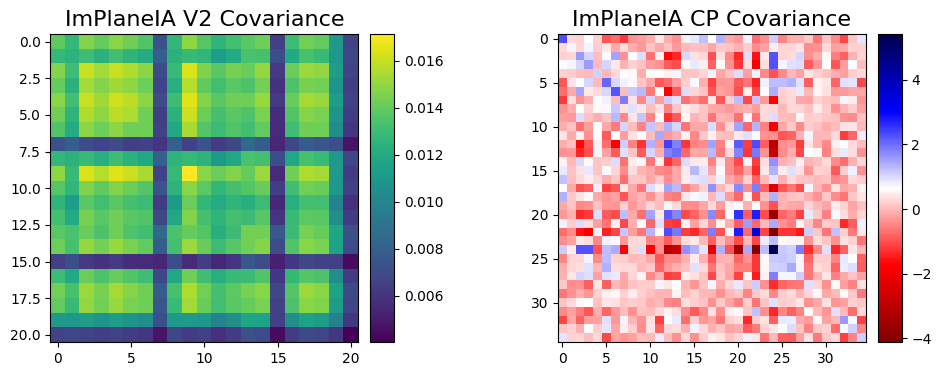

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

img_v2_targcov = ax1.imshow(v2cov,vmin=vmin_v2,vmax=vmax_v2)
cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
plt.colorbar(img_v2_targcov,cax=cax)

ax1.set_title('ImPlaneIA V2 Covariance',fontsize=16)

img_cp_targcov = ax2.imshow(t3cov,vmin=vmin_cp,vmax=vmax_cp, cmap=mpl.cm.seismic_r)
cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
plt.colorbar(img_cp_targcov,cax=cax)

ax2.set_title('ImPlaneIA CP Covariance',fontsize=16)



How does this look in the data space?

(0.0, 34.0)

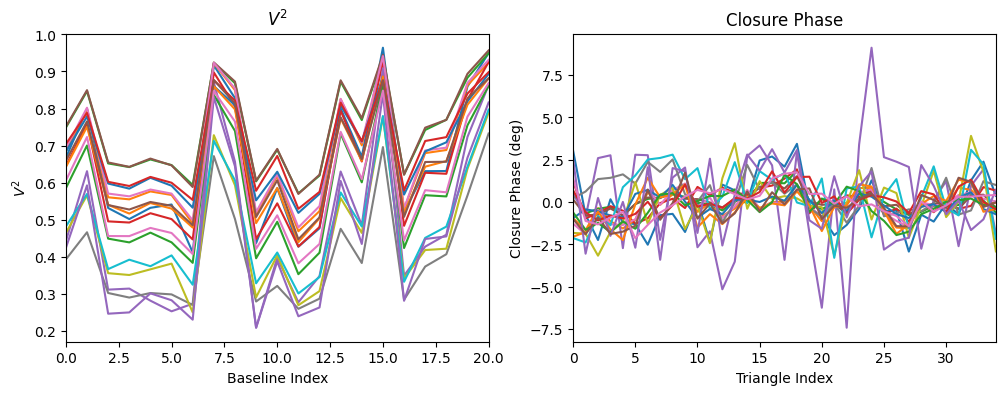

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for j in range(17):
    ax1.plot(v2s[:,j])
    ax2.plot(t3s[:,j])

ax2.set_title('Closure Phase')
ax1.set_ylabel(r'$V^2$')
ax2.set_ylabel('Closure Phase (deg)')
ax1.set_title(r'$V^2$')

ax1.set_xlabel('Baseline Index')
ax1.set_xlim(0, v2s.shape[0]-1)
ax2.set_xlabel('Triangle Index')
ax2.set_xlim(0, t3s.shape[0]-1)

Text(0.5, 0.98, 'All Reduced Data')

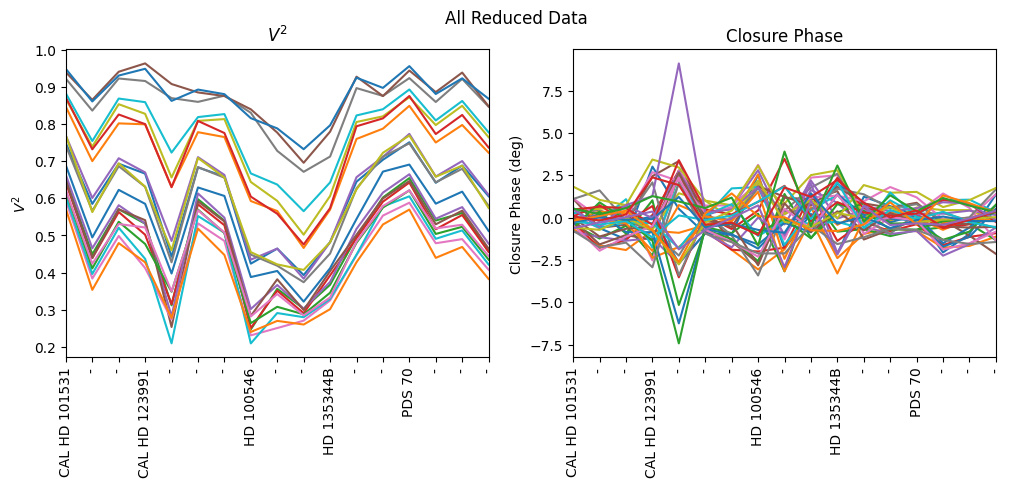

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for j in range(21):
    ax1.plot(v2s[j,args])


for j in range(35):
    ax2.plot(t3s[j,args])

ax1.set_xlim(0,16)
ax2.set_xlim(0,16)
ax1.set_xticks(range(17), groups,rotation=90)
ax2.set_xticks(range(17), groups,rotation=90)

ax1.set_title(r'$V^2$')
ax2.set_title('Closure Phase')
ax1.set_ylabel(r'$V^2$')
ax2.set_ylabel('Closure Phase (deg)')

plt.suptitle('All Reduced Data')

# SAMPip

Let's now look at Joel's data.

Start with uncalibrated data.

In [17]:
joelfnames_all = glob('../data/testing_1242/sampip_joel/*.oifits')
joelcalibs = glob('../data/testing_1242/sampip_joel/CALIB*.oifits')
joelsci = glob('../data/testing_1242/sampip_joel/SCI*.oifits')

joelfnames = joelsci # start with uncalibrated data

print(joelfnames)
joelnumbers = [path.basename(joelfname).split('jw')[1].split('_')[0] for joelfname in joelfnames]
joelnames = [translate[joelnumber] for joelnumber in joelnumbers]
print(joelnames)

['../data/testing_1242/sampip_joel/SCI_uncalib_u_corr_jw01242005001_03102_00001_nis_calints.oifits', '../data/testing_1242/sampip_joel/SCI_uncalib_u_corr_jw01242004001_03102_00001_nis_calints.oifits', '../data/testing_1242/sampip_joel/SCI_uncalib_u_corr_jw01242002001_03102_00001_nis_calints.oifits', '../data/testing_1242/sampip_joel/SCI_uncalib_u_corr_jw01242003001_03102_00001_nis_calints.oifits', '../data/testing_1242/sampip_joel/SCI_uncalib_u_corr_jw01242001001_03102_00001_nis_calints.oifits']
['PDS 70', 'CAL HD 123991', 'CAL HD 101531', 'HD 135344B', 'HD 100546']


In [18]:
v2s_joel, t3s_joel = [], []
v2errs_joel, t3errs_joel = [], []

for j, fname in enumerate(tqdm(joelfnames)):
    name = names[j]
    wavels, band, u, v, vis2, vis2err, t3phi, t3phierr, t3amp, t3amperr, t3u1_joel, t3u2, t3v1_joel, t3v2 = extract_data(fname,joel=True)
    # visibilities
    v2s_joel.append(vis2)
    v2errs_joel.append(vis2err)
    # closure phases
    t3s_joel.append(t3phi)
    t3errs_joel.append(t3phierr)

u_joel, v_joel = u, v

t3phierrs_joel = np.array(t3errs_joel)
t3phis_joel = np.array(t3s_joel)
v2errs_joel = np.array(v2errs_joel)
v2s_joel = np.array(v2s_joel)

100%|██████████| 5/5 [00:00<00:00, 81.20it/s]

No filter in info or as input param?
No filter in info or as input param?
No filter in info or as input param?
No filter in info or as input param?
No filter in info or as input param?


Let's look at how AMICAL and SAMPip compare.

PDS 70 4
CAL HD 123991 4
CAL HD 101531 3
HD 135344B 3
HD 100546 3


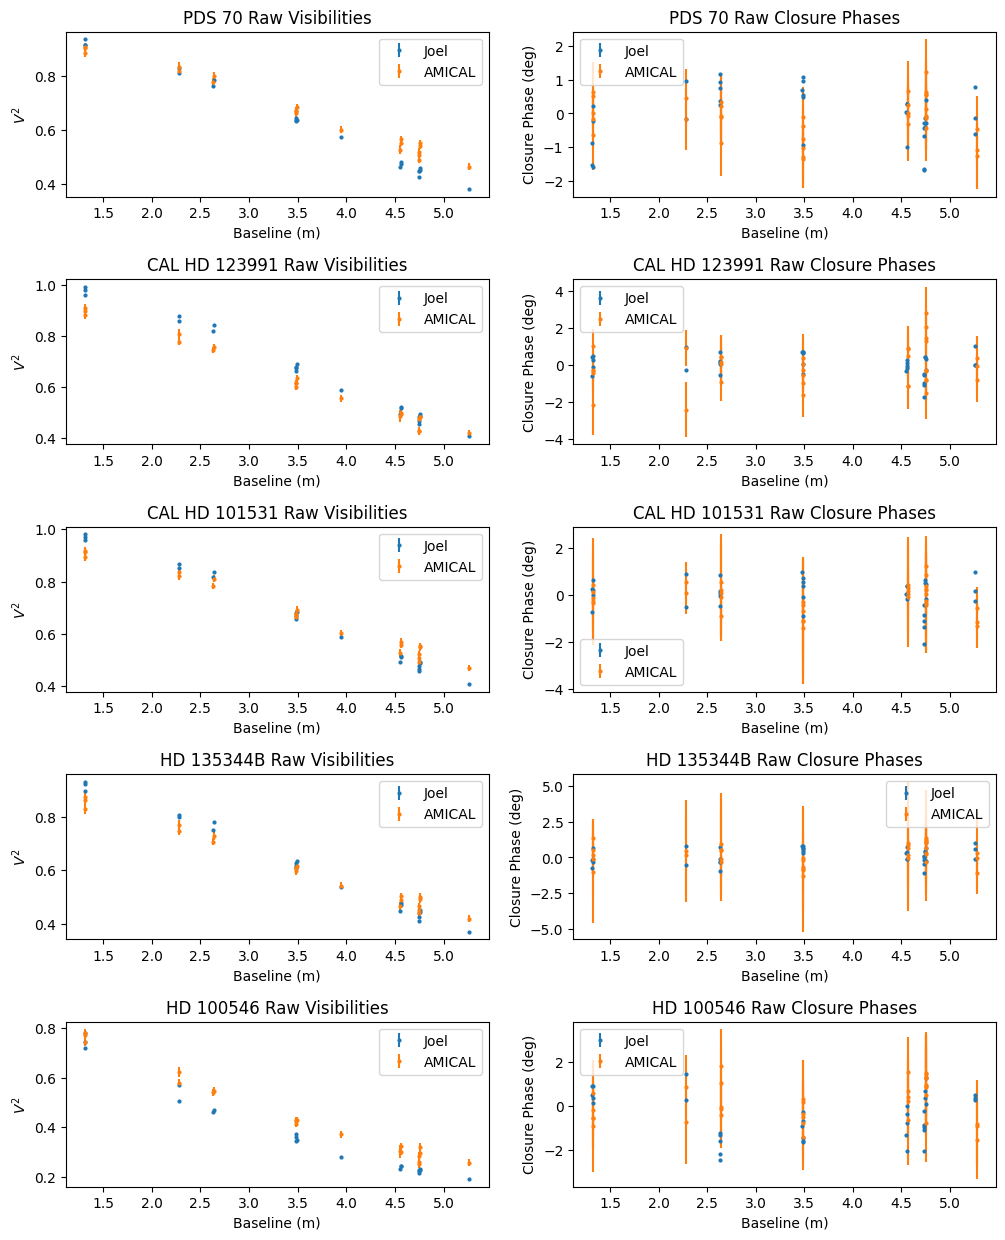

In [19]:
fig, axes = plt.subplots(5,2, figsize=(12, 15))

for j, name in enumerate(joelnames):
    ax1, ax2 = axes[j,:]

    match = np.array(names)==name
    print(name, np.sum(match))
    
    v2_amical = v2s[:,match].mean(axis=1)
    v2errs_amical = v2errs[:,match].mean(axis=1)
    t3_amical = t3s[:,match].mean(axis=1)
    t3errs_amical = t3errs[:,match].mean(axis=1)

    # visibilities
    ax1.errorbar(np.sqrt(u_joel**2 + v_joel**2), v2s_joel[j,:], yerr=v2errs_joel[j,:], fmt='o',markersize=2,label='Joel')
    ax1.set_xlabel('Baseline (m)')
    ax1.set_ylabel(r'$V^2$')
    ax1.set_title(name+' Raw Visibilities')
    ax1.errorbar(np.sqrt(u**2 + v**2), v2_amical,yerr=v2errs_amical,fmt='o',markersize=2,label='AMICAL')
    ax1.legend()

    # closure phases vs first baseline
    ax2.errorbar(np.sqrt(t3u1_joel**2 + t3v1_joel**2), t3phis_joel[j,:], yerr=t3phierrs_joel[j,:], fmt='o',markersize=2,label='Joel')
    ax2.errorbar(np.sqrt(t3u1**2 + t3v1**2), t3_amical, yerr=t3errs_amical, fmt='o',markersize=2,label='AMICAL')
    ax2.set_xlabel('Baseline (m)')
    ax2.set_ylabel('Closure Phase (deg)')
    ax2.set_title(name + ' Raw Closure Phases')
    ax2.legend()

plt.subplots_adjust(hspace=0.5)


Now let's try to replicate the calibration strategy.

From Joel: 
>    The CALIB_* files are the calibrated OIFITS data of the three targets 
using an average of the transfer function from the two calibrators


In [20]:
is_calib = np.array([name.startswith('CAL') for name in joelnames])
print(is_calib)
v2_otf_joel = np.mean(v2s_joel[is_calib,:],axis=0)
t3_tf_joel = np.mean(t3phis_joel[is_calib,:],axis=0)

# now do the same for AMICAL
is_calib = np.array([name.startswith('CAL') for name in names])
print(is_calib)
v2_otf_amical = 10**np.mean(np.log10(v2s[:,is_calib]),axis=1) # geometric mean of calibrator visibilities
t3_tf_amical = np.mean(t3s[:,is_calib],axis=1)

[False  True  True False False]
[ True False  True False  True False  True False False False  True False
  True False False  True False]


In [21]:
joelfnames = joelcalibs # now let's look at calibrated data

print(joelfnames)
joelnumbers = [path.basename(joelfname).split('jw')[1].split('_')[0] for joelfname in joelfnames]
joelnames = [translate[joelnumber] for joelnumber in joelnumbers]
print(joelnames)

['../data/testing_1242/sampip_joel/CALIB_Cal_SCI_uncalib_u_corr_jw01242001001_03102_00001_nis_calints.oifits', '../data/testing_1242/sampip_joel/CALIB_Cal_SCI_uncalib_u_corr_jw01242003001_03102_00001_nis_calints.oifits', '../data/testing_1242/sampip_joel/CALIB_Cal_SCI_uncalib_u_corr_jw01242005001_03102_00001_nis_calints.oifits']
['HD 100546', 'HD 135344B', 'PDS 70']


In [22]:
v2s_joel, t3s_joel = [], []
v2errs_joel, t3errs_joel = [], []

for j, fname in enumerate(tqdm(joelfnames)):
    name = names[j]
    wavels, band, u, v, vis2, vis2err, t3phi, t3phierr, t3amp, t3amperr, t3u1_joel, t3u2, t3v1_joel, t3v2 = extract_data(fname,joel=True)
    # visibilities
    v2s_joel.append(vis2)
    v2errs_joel.append(vis2err)
    # closure phases
    t3s_joel.append(t3phi)
    t3errs_joel.append(t3phierr)

u_joel, v_joel = u, v

t3phierrs_joel = np.array(t3errs_joel)
t3phis_joel = np.array(t3s_joel)
v2errs_joel = np.array(v2errs_joel)
v2s_joel = np.array(v2s_joel)

100%|██████████| 3/3 [00:00<00:00, 88.74it/s]

No filter in info or as input param?
No filter in info or as input param?
No filter in info or as input param?


In [23]:
v2s_calib = (v2s.T / v2_otf_amical).T
t3s_calib = (t3s.T - t3_tf_amical).T

HD 100546 3
HD 135344B 3
PDS 70 4


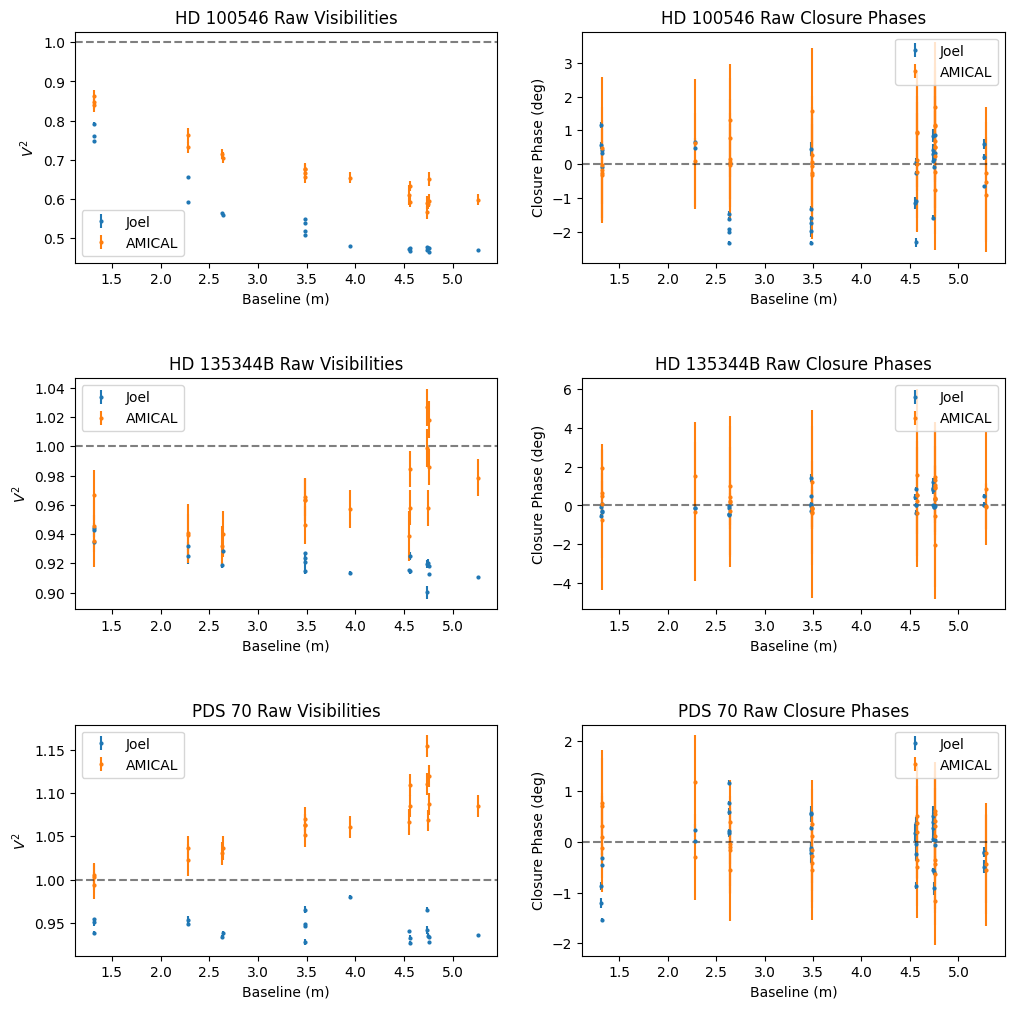

In [24]:
# now calibrate the amical data the same way


fig, axes = plt.subplots(3,2, figsize=(12, 12))

for j, name in enumerate(joelnames):
    
    ax1, ax2 = axes[j,:]
    match = np.array(names)==name
    print(name, np.sum(match))

    v2_amical = v2s_calib[:,match].mean(axis=1)
    v2errs_amical = v2errs[:,match].mean(axis=1)
    t3_amical = t3s_calib[:,match].mean(axis=1)
    t3errs_amical = t3errs[:,match].mean(axis=1)

    # visibilities
    ax1.errorbar(np.sqrt(u_joel**2 + v_joel**2), v2s_joel[j,:], yerr=v2errs_joel[j,:], fmt='o',markersize=2,label='Joel')
    ax1.set_xlabel('Baseline (m)')
    ax1.set_ylabel(r'$V^2$')
    ax1.set_title(name+' Raw Visibilities')
    ax1.errorbar(np.sqrt(u**2 + v**2), v2_amical,yerr=v2errs_amical,fmt='o',markersize=2,label='AMICAL')
    ax1.axhline(1.0, color='k', linestyle='--', alpha=0.5)
    ax1.legend()


    # closure phases vs first baseline
    ax2.errorbar(np.sqrt(t3u1_joel**2 + t3v1_joel**2), t3phis_joel[j,:], yerr=t3phierrs_joel[j,:], fmt='o',markersize=2,label='Joel')
    ax2.errorbar(np.sqrt(t3u1**2 + t3v1**2), t3_amical, yerr=t3errs_amical, fmt='o',markersize=2,label='AMICAL')
    ax2.set_xlabel('Baseline (m)')
    ax2.set_ylabel('Closure Phase (deg)')
    ax2.set_title(name + ' Raw Closure Phases')
    ax2.axhline(0.0, color='k', linestyle='--', alpha=0.5)
    ax2.legend()

plt.subplots_adjust(hspace=0.5)


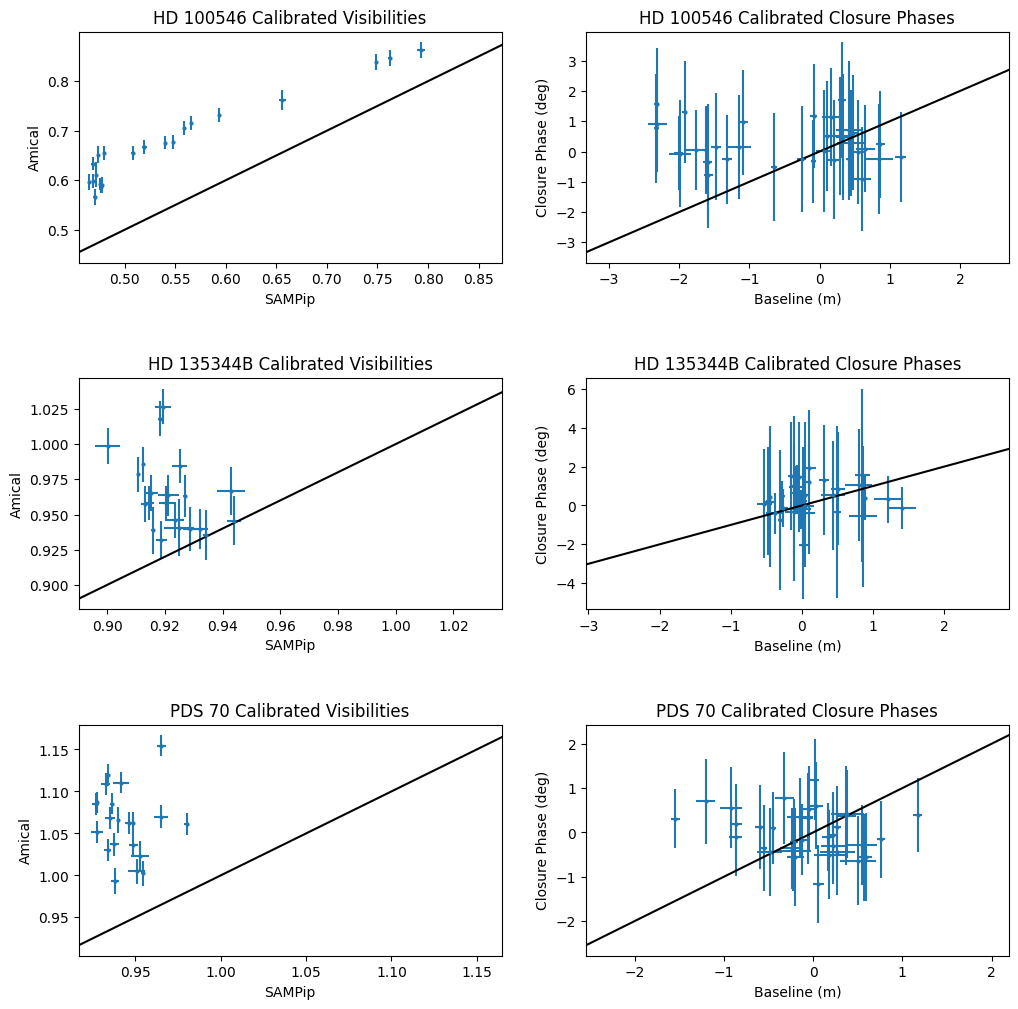

In [25]:
# correlation plots

fig, axes = plt.subplots(3,2, figsize=(12, 12))

for j, name in enumerate(joelnames):
    
    ax1, ax2 = axes[j,:]
    match = np.array(names)==name

    v2_amical = v2s_calib[:,match].mean(axis=1)
    v2errs_amical = v2errs[:,match].mean(axis=1)
    t3_amical = t3s_calib[:,match].mean(axis=1)
    t3errs_amical = t3errs[:,match].mean(axis=1)

    # visibilities
    ax1.errorbar(v2s_joel[j,:], v2_amical, xerr=v2errs_joel[j,:], yerr=v2errs_amical, fmt='o',markersize=2)
    v2min, v2max = np.nanmin(np.concatenate([v2s_joel[j,:], v2_amical])), np.nanmax(np.concatenate([v2s_joel[j,:], v2_amical]))
    ax1.plot([v2min-0.01,v2max+0.01],[v2min-0.01,v2max+0.01],color='k')
    ax1.set_xlim(v2min-0.01,v2max+0.01)
    ax1.set_xlabel('SAMPip')
    ax1.set_ylabel(r'Amical')
    ax1.set_title(name+' Calibrated Visibilities')

    # closure phases vs first baseline
    ax2.errorbar(t3phis_joel[j,:], t3_amical, xerr=t3phierrs_joel[j,:], yerr=t3errs_amical, fmt='o',markersize=2)
    t3min, t3max = np.nanmin(np.concatenate([t3phis_joel[j,:], t3_amical])), np.nanmax(np.concatenate([t3phis_joel[j,:], t3_amical]))
    ax2.plot([t3min-1,t3max+1],[t3min-1,t3max+1],color='k')
    ax2.set_xlim(t3min-1,t3max+1)
    ax2.set_xlabel('Baseline (m)')
    ax2.set_ylabel('Closure Phase (deg)')
    ax2.set_title(name + ' Calibrated Closure Phases')

plt.subplots_adjust(hspace=0.5)


This is just a first stab, but it does seem to indicate that the AMICAL calibration is off compared to SAMPip.